In [ ]:
# Setup & Data Load
import pandas as pd
import numpy as np

# Reproducibility
RANDOM_STATE = 42

# Data path
DATA_PATH = "/content/dataset.csv"
df = pd.read_csv(DATA_PATH)

# Keep an untouched original for reference
df_raw = df.copy(deep=True)

# Quick, readable preview
print("Shape:", df.shape)
display(df.head(3))

# Overview of dtypes and non-null counts
print("\nInfo:")
print(df.info())

# Basic target inspection
if "Recurred" in df.columns:
    print("\nTarget distribution (Recurred):")
    print(df["Recurred"].value_counts(dropna=False))
    print("\nTarget distribution (%):")
    print(df["Recurred"].value_counts(normalize=True).mul(100).round(2))
else:
    print("\n[Warning] 'Recurred' column not found.")

# Missing values check
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))

# Duplicate rows check
dup_count = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_count}")

# Peek at unique values for a few key categorical columns to understand encoding
cat_peek_cols = [
    "Gender","Smoking","Hx Smoking","Hx Radiothreapy","Thyroid Function",
    "Adenopathy","Pathology","Focality","Risk","T","N","M","Stage","Response","Recurred"
]
print("\nUnique values (sample key columns):")
for c in cat_peek_cols:
    if c in df.columns:
        vals = df[c].astype(str).unique()
        print(f"- {c}: {sorted(vals)[:12]}{' ...' if len(vals) > 12 else ''}")

Shape: (383, 17)


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-nul

In [ ]:
# Data Cleaning

# Remove duplicate rows
print(f"Before deduplication: {df.shape[0]} rows")
df = df.drop_duplicates()
print(f"After deduplication: {df.shape[0]} rows")

# Strip leading/trailing spaces in column names & string values
df.columns = df.columns.str.strip()
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

# Fix common typos / standardize categories (example: Pathology)
df['Pathology'] = df['Pathology'].replace({
    'Hurthel cell': 'Hurthle cell'
})

# Sanity check unique values after cleaning
print("\nUnique 'Pathology' values after cleaning:")
print(sorted(df['Pathology'].unique()))

Before deduplication: 383 rows
After deduplication: 364 rows

Unique 'Pathology' values after cleaning:
['Follicular', 'Hurthle cell', 'Micropapillary', 'Papillary']


In [ ]:
# Train/Test Split
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=['Recurred'])
y = df['Recurred']

# Encode target to binary now for model training
y_encoded = y.map({'No': 0, 'Yes': 1})

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Train target distribution:\n{y_train.value_counts(normalize=True).round(3)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True).round(3)}")

Train set: (291, 16), Test set: (73, 16)
Train target distribution:
Recurred
0    0.704
1    0.296
Name: proportion, dtype: float64
Test target distribution:
Recurred
0    0.699
1    0.301
Name: proportion, dtype: float64


In [ ]:
# Preprocessing Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify column types
num_features = ['Age']
cat_features = X_train.select_dtypes(include='object').columns.tolist()

# Preprocessor: scale numeric, one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Fit the preprocessor on training data only (to avoid data leakage)
preprocessor.fit(X_train)

# Transform a small sample to inspect shape
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Transformed train shape:", X_train_transformed.shape)
print("Transformed test shape:", X_test_transformed.shape)

Transformed train shape: (291, 55)
Transformed test shape: (73, 55)


In [ ]:
# Baseline Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Create + fit model (with higher max_iter for convergence on many features)
log_reg = LogisticRegression(max_iter=200, random_state=RANDOM_STATE)
log_reg.fit(X_train_transformed, y_train)

# Predictions
y_pred = log_reg.predict(X_test_transformed)
y_proba = log_reg.predict_proba(X_test_transformed)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

Classification Report:
               precision    recall  f1-score   support

           0      0.980     0.941     0.960        51
           1      0.875     0.955     0.913        22

    accuracy                          0.945        73
   macro avg      0.927     0.948     0.937        73
weighted avg      0.948     0.945     0.946        73

Confusion Matrix:
 [[48  3]
 [ 1 21]]
ROC-AUC: 0.975


In [ ]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    class_weight='balanced',  # give more weight to minority class
    n_jobs=-1
)
rf_clf.fit(X_train_transformed, y_train)

# Predictions & evaluation
y_pred_rf = rf_clf.predict(X_test_transformed)
y_proba_rf = rf_clf.predict_proba(X_test_transformed)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred_rf, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.3f}")

Classification Report:
               precision    recall  f1-score   support

           0      0.980     0.941     0.960        51
           1      0.875     0.955     0.913        22

    accuracy                          0.945        73
   macro avg      0.927     0.948     0.937        73
weighted avg      0.948     0.945     0.946        73

Confusion Matrix:
 [[48  3]
 [ 1 21]]
ROC-AUC: 0.974


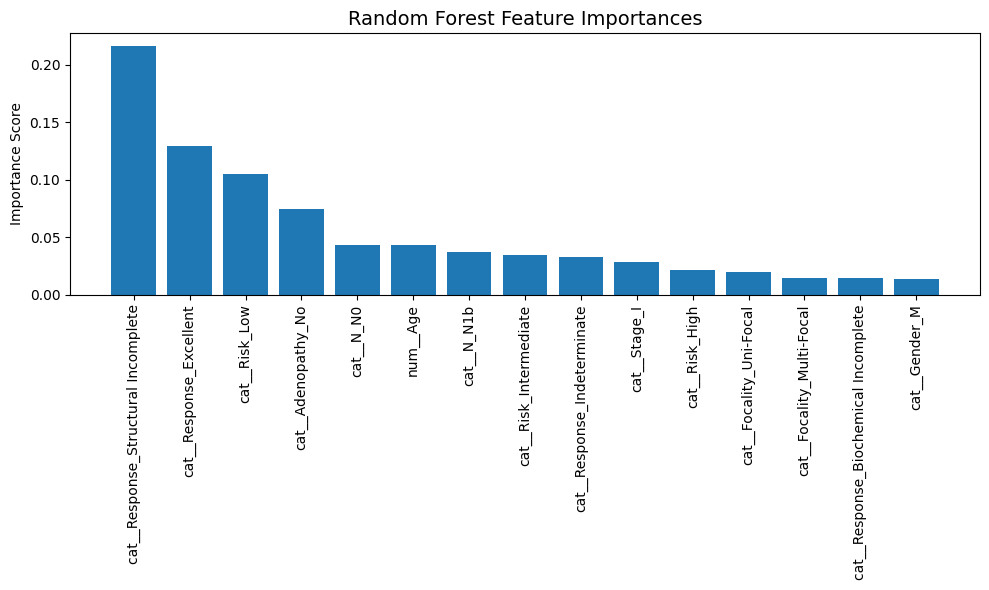

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importances from the trained RF model
importances = rf_clf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances", fontsize=14)
plt.bar(range(15), importances[indices][:15], align='center')
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=90)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

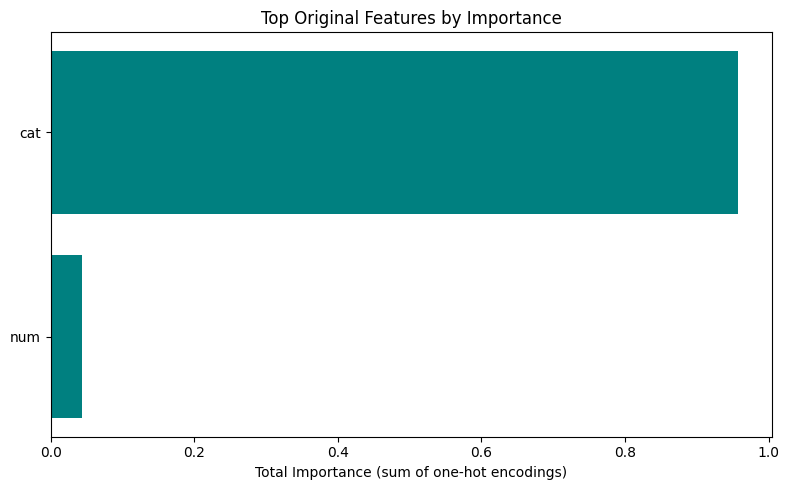

,Original Feature,Total Importance
1,cat,0.957062
0,num,0.042938


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get model importances and matching one-hot feature names
importances = rf_clf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Map one-hot features back to their source column
grouped_importances = {}
for feat_name, importance in zip(feature_names, importances):
    # Original col is before the '_' in feature name (for one-hots),
    # or matches the numeric feature name exactly
    if "_" in feat_name:
        orig_col = feat_name.split("_", 1)[0]
    else:
        orig_col = feat_name
    grouped_importances[orig_col] = grouped_importances.get(orig_col, 0) + importance

# Convert to sorted DataFrame
grouped_df = pd.DataFrame({
    'Original Feature': list(grouped_importances.keys()),
    'Total Importance': list(grouped_importances.values())
}).sort_values(by='Total Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(grouped_df['Original Feature'][:10][::-1],
         grouped_df['Total Importance'][:10][::-1],
         color='teal')
plt.xlabel("Total Importance (sum of one-hot encodings)")
plt.title("Top Original Features by Importance")
plt.tight_layout()
plt.show()

grouped_df

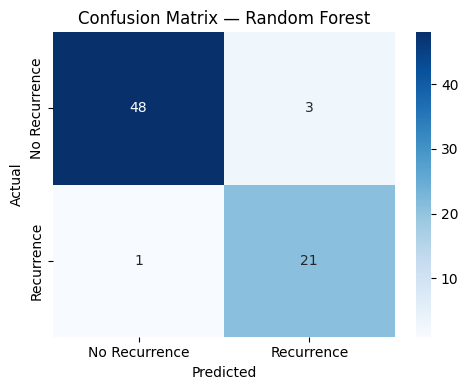

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Recurrence', 'Recurrence'],
            yticklabels=['No Recurrence', 'Recurrence'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix — Random Forest')
plt.tight_layout()
plt.show()

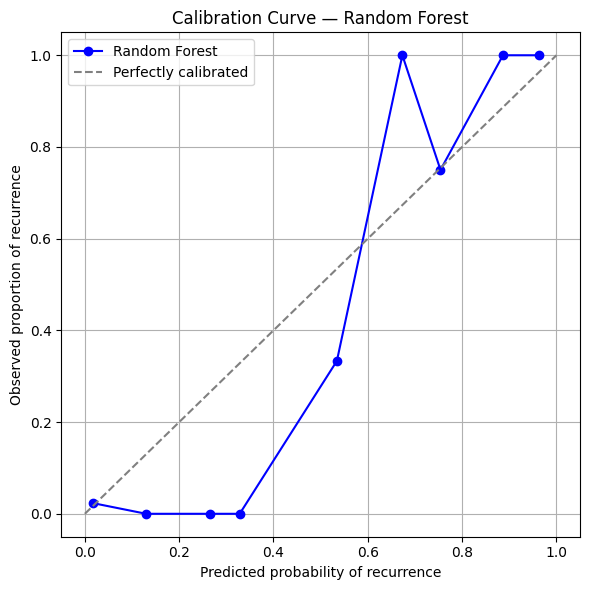

In [15]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Predicted probabilities for the positive class
y_proba_rf = rf_clf.predict_proba(X_test_transformed)[:, 1]

# Get calibration data
prob_true, prob_pred = calibration_curve(y_test, y_proba_rf, n_bins=10)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

plt.title('Calibration Curve — Random Forest')
plt.xlabel('Predicted probability of recurrence')
plt.ylabel('Observed proportion of recurrence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()